# USAD

## Environment

In [1]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [2]:
# !git clone https://github.com/manigalati/usad

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [4]:
!nvidia-smi -L

device = get_default_device()
device

GPU 0: NVIDIA RTX A6000 (UUID: GPU-4fe1f960-ffc5-eb69-03c5-6f101fe9f547)


device(type='cpu')

## EDA - Data Pre-Processing

In [5]:
down_rate=5

### Download dataset

In [6]:
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

mkdir: cannot create directory ‘input’: File exists
input/SWaT_Dataset_Normal_v1.csv [Exists]
input/SWaT_Dataset_Attack_v0.csv [Exists]


### Normal period

In [7]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)

normal.shape

/home/suraj/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(495000, 51)

In [8]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

In [ ]:
#Downsampling
normal=normal.groupby(np.arange(len(normal.index)) // 5).mean()

#### Normalization

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

# x = normal.values
# x_max=np.nanmax(x) 
# x_min=np.nanmin(x)
# x_std = (x - x_min)/(x_max - x_min)
# normal = pd.DataFrame(x_std)

In [10]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [11]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

/home/suraj/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(449919, 51)

In [12]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

In [ ]:
#Downsampling the attack data
attack=attack.groupby(np.arange(len(attack.index)) // down_rate).mean()
attack.shape

In [ ]:
#Downsampling the labels
labels_down=[]

for i in range(len(labels)//down_rate):
    if labels[5*i:5*(i+1)].count(1.0):
        labels_down.append(1.0) #Attack
    else:
        labels_down.append(0.0) #Normal

#for the last few labels that are not within a full-length window
if labels[down_rate*(i+1):].count(1.0):
    labels_down.append(1.0) #Attack
else:
    labels_down.append(0.0) #Normal

print(len(labels_down))

#### Normalization

In [13]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

# x = attack.values 
# x_std = (x - x_min)/(x_max - x_min)
# attack = pd.DataFrame(x_std)

In [14]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


### Windows

In [15]:
window_size=12

In [16]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [17]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [18]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 70
hidden_size = 40

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [19]:
# history = training(N_EPOCHS,model,train_loader,val_loader)

In [20]:
# plot_history(history)

In [21]:
# torch.save({
#             'encoder': model.encoder.state_dict(),
#             'decoder1': model.decoder1.state_dict(),
#             'decoder2': model.decoder2.state_dict()
#             }, "model_SWaT.pth")

#### Another way to save the model!

In [22]:
import pickle

In [23]:
# filename = 'usad_model_SWaT.sav'
# pickle.dump(model, open(filename, 'wb'))

In [24]:
# load the model
filename = 'usad_model_SWaT.sav'
loaded_model = pickle.load(open(filename, 'rb'))

## Testing

In [25]:
checkpoint = torch.load("model_SWaT.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [26]:
training_scores_list=training_scores(model,train_loader)

In [27]:
training_scores_list

[tensor([0.3293, 0.3293, 0.3293,  ..., 0.0591, 0.0591, 0.0591],
        grad_fn=<AddBackward0>),
 tensor([0.0592, 0.0592, 0.0592,  ..., 0.0461, 0.0462, 0.0462],
        grad_fn=<AddBackward0>),
 tensor([0.0463, 0.0463, 0.0464,  ..., 0.0488, 0.0488, 0.0488],
        grad_fn=<AddBackward0>),
 tensor([0.0488, 0.0487, 0.0488,  ..., 0.0596, 0.0596, 0.0595],
        grad_fn=<AddBackward0>),
 tensor([0.0595, 0.0595, 0.0595,  ..., 0.0885, 0.0884, 0.0883],
        grad_fn=<AddBackward0>),
 tensor([0.0883, 0.0882, 0.0882,  ..., 0.0454, 0.0455, 0.0454],
        grad_fn=<AddBackward0>),
 tensor([0.0454, 0.0454, 0.0453,  ..., 0.0524, 0.0524, 0.0523],
        grad_fn=<AddBackward0>),
 tensor([0.0523, 0.0523, 0.0523,  ..., 0.0485, 0.0486, 0.0487],
        grad_fn=<AddBackward0>),
 tensor([0.0487, 0.0488, 0.0488,  ..., 0.0854, 0.0854, 0.0854],
        grad_fn=<AddBackward0>),
 tensor([0.0854, 0.0854, 0.0854,  ..., 0.1046, 0.1046, 0.1047],
        grad_fn=<AddBackward0>),
 tensor([0.1047, 0.1048, 0.104

In [28]:
training_scores_concat=np.concatenate([torch.stack(training_scores_list[:-1]).flatten().detach().cpu().numpy(),
                            training_scores_list[-1].flatten().detach().cpu().numpy()])

In [29]:
print(training_scores_concat)

[0.3292689  0.3292666  0.32927644 ... 0.01915107 0.0191438  0.01913451]


In [30]:
min(training_scores_concat)

0.0063223615

In [31]:
results=training_scores(model, test_loader) # testing

In [32]:
print(results)

[tensor([0.0100, 0.0100, 0.0101,  ..., 0.0548, 0.0549, 0.0549],
       grad_fn=<AddBackward0>), tensor([0.0549, 0.0549, 0.0549,  ..., 0.1632, 0.1635, 0.1637],
       grad_fn=<AddBackward0>), tensor([0.1640, 0.1642, 0.1645,  ..., 0.0100, 0.0100, 0.0100],
       grad_fn=<AddBackward0>), tensor([0.0100, 0.0101, 0.0101,  ..., 0.0220, 0.0220, 0.0220],
       grad_fn=<AddBackward0>), tensor([0.0220, 0.0220, 0.0220,  ..., 0.0124, 0.0125, 0.0126],
       grad_fn=<AddBackward0>), tensor([0.0127, 0.0127, 0.0128,  ..., 0.0586, 0.0586, 0.0585],
       grad_fn=<AddBackward0>), tensor([0.0585, 0.0584, 0.0583,  ..., 0.0315, 0.0321, 0.0314],
       grad_fn=<AddBackward0>), tensor([0.0305, 0.0295, 0.0286,  ..., 0.0689, 0.0689, 0.0689],
       grad_fn=<AddBackward0>), tensor([0.0689, 0.0689, 0.0689,  ..., 0.0860, 0.0861, 0.0861],
       grad_fn=<AddBackward0>), tensor([0.0862, 0.0863, 0.0864,  ..., 0.0126, 0.0126, 0.0126],
       grad_fn=<AddBackward0>), tensor([0.0126, 0.0126, 0.0127,  ..., 0.0116, 0.0

In [33]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [34]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels] # this is with the point adjust?

In [35]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                            results[-1].flatten().detach().cpu().numpy()])

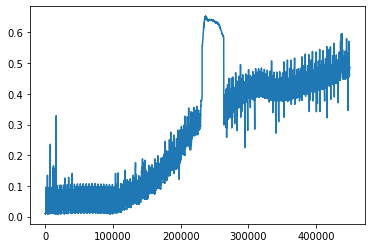

In [36]:
plt.plot(range(len(y_pred)),y_pred)

In [37]:
results_threshold=testing_threshold(model,test_loader,alpha=.5, beta=.5, contamination=0.10)

In [38]:
results_threshold

0.47617567

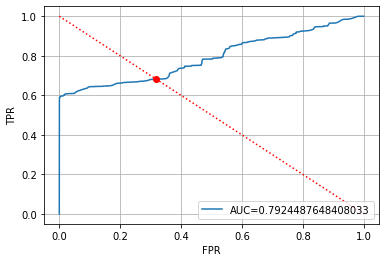

array([0.39044714], dtype=float32)

In [39]:
threshold=ROC(y_test,y_pred)
threshold

In [40]:
threshold=results_threshold # Decide on your own threshold
y_pred_label = [1.0 if (score > threshold) else 0 for score in y_pred ]

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
prec=precision_score(y_test,y_pred_label,pos_label=1)
recall=recall_score(y_test,y_pred_label,pos_label=1)
f1=f1_score(y_test,y_pred_label,pos_label=1)
print('precision=',prec)
print('recall=',recall)
print('f1=',f1)


precision= 0.7440542342742832
recall= 0.6085699741846344
f1= 0.6695267810712429


In [42]:
data = {"y_pred":y_pred,
       'y_test':y_test}
df = pd.DataFrame(data)
df

,y_pred,y_test
0,0.009966,0.0
1,0.010022,0.0
2,0.010071,0.0
3,0.010106,0.0
4,0.010117,0.0
...,...,...
449902,0.486704,0.0
449903,0.486691,0.0
449904,0.486670,0.0
449905,0.486629,0.0


In [43]:
df.to_csv('results_swat.csv')

In [3]:
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")
attack

/home/suraj/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,"2,427057","522,8467",2,2,1,"262,0161","8,396437","328,6337","2,445391",...,2,1,"250,8652","1,649953","189,5988","0,000128152",1,1,1,Normal
1,28/12/2015 10:00:01 AM,"2,446274","522,886",2,2,1,"262,0161","8,396437","328,6337","2,445391",...,2,1,"250,8652","1,649953","189,6789","0,000128152",1,1,1,Normal
2,28/12/2015 10:00:02 AM,"2,489191","522,8467",2,2,1,"262,0161","8,394514","328,6337","2,442316",...,2,1,"250,8812","1,649953","189,6789","0,000128152",1,1,1,Normal
3,28/12/2015 10:00:03 AM,"2,53435","522,9645",2,2,1,"262,0161","8,394514","328,6337","2,442316",...,2,1,"250,8812","1,649953","189,6148","0,000128152",1,1,1,Normal
4,28/12/2015 10:00:04 AM,"2,56926","523,4748",2,2,1,"262,0161","8,394514","328,6337","2,443085",...,2,1,"250,8812","1,649953","189,5027","0,000128152",1,1,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2/1/2016 2:59:55 PM,"2,559972","519,5495",2,2,1,"168,0979","8,638683","301,9226","2,459488",...,2,1,"251,1535","0,8650241","189,022",0,1,1,1,Normal
449915,2/1/2016 2:59:56 PM,"2,549082","520,4131",2,2,1,"168,0979","8,638683","301,9226","2,459488",...,2,1,"251,0734","0,8650241","188,9259",0,1,1,1,Normal
449916,2/1/2016 2:59:57 PM,"2,531467","520,6878",2,2,1,"168,0979","8,638683","301,9226","2,460129",...,2,1,"251,0734","0,8650241","188,9259",0,1,1,1,Normal
449917,2/1/2016 2:59:58 PM,"2,521218","520,7271",2,2,1,"168,0979","8,638683","301,9226","2,460129",...,2,1,"251,0734","0,8650241","188,9259",0,1,1,1,Normal


In [5]:
window_size = 12
attack_timestamp = attack['Timestamp']
attack_timestamp[window_size:]

12         28/12/2015 10:00:12 AM
13         28/12/2015 10:00:13 AM
14         28/12/2015 10:00:14 AM
15         28/12/2015 10:00:15 AM
16         28/12/2015 10:00:16 AM
                   ...           
449914        2/1/2016 2:59:55 PM
449915        2/1/2016 2:59:56 PM
449916        2/1/2016 2:59:57 PM
449917        2/1/2016 2:59:58 PM
449918        2/1/2016 2:59:59 PM
Name: Timestamp, Length: 449907, dtype: object

In [13]:
df = pd.read_csv('results_swat.csv')
df.index = attack_timestamp[window_size:]
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df

,y_pred,y_test
Timestamp,,
28/12/2015 10:00:12 AM,0.009966,0.0
28/12/2015 10:00:13 AM,0.010022,0.0
28/12/2015 10:00:14 AM,0.010071,0.0
28/12/2015 10:00:15 AM,0.010106,0.0
28/12/2015 10:00:16 AM,0.010117,0.0
...,...,...
2/1/2016 2:59:55 PM,0.486704,0.0
2/1/2016 2:59:56 PM,0.486691,0.0
2/1/2016 2:59:57 PM,0.486670,0.0


In [14]:
df.to_csv('results_swat.csv')

In [15]:
df

,y_pred,y_test
Timestamp,,
28/12/2015 10:00:12 AM,0.009966,0.0
28/12/2015 10:00:13 AM,0.010022,0.0
28/12/2015 10:00:14 AM,0.010071,0.0
28/12/2015 10:00:15 AM,0.010106,0.0
28/12/2015 10:00:16 AM,0.010117,0.0
...,...,...
2/1/2016 2:59:55 PM,0.486704,0.0
2/1/2016 2:59:56 PM,0.486691,0.0
2/1/2016 2:59:57 PM,0.486670,0.0


In [18]:
df.index = pd.to_datetime(df.index)
df

,y_pred,y_test
Timestamp,,
2015-12-28 10:00:12,0.009966,0.0
2015-12-28 10:00:13,0.010022,0.0
2015-12-28 10:00:14,0.010071,0.0
2015-12-28 10:00:15,0.010106,0.0
2015-12-28 10:00:16,0.010117,0.0
...,...,...
2016-02-01 14:59:55,0.486704,0.0
2016-02-01 14:59:56,0.486691,0.0
2016-02-01 14:59:57,0.486670,0.0


In [19]:
df

,y_pred,y_test
Timestamp,,
2015-12-28 10:00:12,0.009966,0.0
2015-12-28 10:00:13,0.010022,0.0
2015-12-28 10:00:14,0.010071,0.0
2015-12-28 10:00:15,0.010106,0.0
2015-12-28 10:00:16,0.010117,0.0
...,...,...
2016-02-01 14:59:55,0.486704,0.0
2016-02-01 14:59:56,0.486691,0.0
2016-02-01 14:59:57,0.486670,0.0


In [20]:
filt = df['y_pred']>0.47617567
df[filt]

,y_pred,y_test
Timestamp,,
2015-12-31 02:22:49,0.482859,1.0
2015-12-31 02:22:50,0.492416,1.0
2015-12-31 02:22:51,0.501997,1.0
2015-12-31 02:22:52,0.511386,1.0
2015-12-31 02:22:53,0.520323,1.0
...,...,...
2016-02-01 14:59:55,0.486704,0.0
2016-02-01 14:59:56,0.486691,0.0
2016-02-01 14:59:57,0.486670,0.0


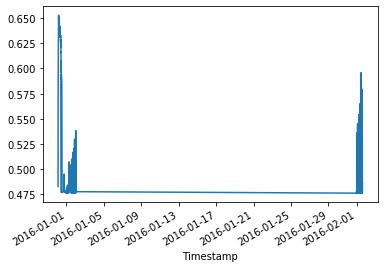

In [21]:
df[filt]['y_pred'].plot()

In [22]:
df[filt].index

DatetimeIndex(['2015-12-31 02:22:49', '2015-12-31 02:22:50',
               '2015-12-31 02:22:51', '2015-12-31 02:22:52',
               '2015-12-31 02:22:53', '2015-12-31 02:22:54',
               '2015-12-31 02:22:55', '2015-12-31 02:22:56',
               '2015-12-31 02:22:57', '2015-12-31 02:22:58',
               ...
               '2016-02-01 14:59:50', '2016-02-01 14:59:51',
               '2016-02-01 14:59:52', '2016-02-01 14:59:53',
               '2016-02-01 14:59:54', '2016-02-01 14:59:55',
               '2016-02-01 14:59:56', '2016-02-01 14:59:57',
               '2016-02-01 14:59:58', '2016-02-01 14:59:59'],
              dtype='datetime64[ns]', name='Timestamp', length=44990, freq=None)

In [37]:
(df[filt].index[1]-df[filt].index[0]).seconds ==1

True

In [48]:
anomaly_start = []
start = df[filt].index[0]
count = 0
for time in df[filt].index:
    if (time - start).seconds == 1:
        start = time
        count += 1 
    else:
        anomaly_start.append([start,count])
        count = 0
        start = time
anomaly_start     

[[Timestamp('2015-12-31 02:22:49'), 0],
 [Timestamp('2015-12-31 11:16:45'), 32036],
 [Timestamp('2015-12-31 11:17:06'), 7],
 [Timestamp('2015-12-31 18:09:32'), 26],
 [Timestamp('2015-12-31 21:29:50'), 13],
 [Timestamp('2016-01-01 00:23:51'), 15],
 [Timestamp('2016-01-01 01:35:52'), 16],
 [Timestamp('2016-01-01 02:46:53'), 17],
 [Timestamp('2016-01-01 03:58:52'), 13],
 [Timestamp('2016-01-01 05:11:50'), 8],
 [Timestamp('2016-01-01 06:56:01'), 32],
 [Timestamp('2016-01-01 12:00:02'), 30],
 [Timestamp('2016-01-01 13:27:04'), 34],
 [Timestamp('2016-01-01 14:22:56'), 16],
 [Timestamp('2016-01-01 14:55:05'), 35],
 [Timestamp('2016-01-01 15:50:55'), 13],
 [Timestamp('2016-01-01 16:23:07'), 39],
 [Timestamp('2016-01-01 17:18:55'), 11],
 [Timestamp('2016-01-01 17:50:57'), 16],
 [Timestamp('2016-01-01 18:47:58'), 17],
 [Timestamp('2016-01-01 19:20:10'), 43],
 [Timestamp('2016-01-01 20:15:02'), 26],
 [Timestamp('2016-01-01 20:48:01'), 99],
 [Timestamp('2016-01-01 21:43:02'), 25],
 [Timestamp('201

In [49]:
count

310